In [1]:
import sys
import ROOT
import numpy as np
import pandas as pd
import root_pandas
import seaborn as sb
import matplotlib.pyplot as plt
import uproot
import time

from itertools import product

#from root_numpy import root2array

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

Welcome to JupyROOT 6.16/00


/Users/jonamotta/anaconda3/envs/python_root/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
Using TensorFlow backend.


In [2]:
########################################
### READ TREES AND CREATE DATAFRAMES ###
########################################


# fix random seed for reproducibility
np.random.seed(1986)

#create DataFrames with the values coming from the trees
file_tau = uproot.open('bc_jpsi_tau_nu_gen.root')
tree_tau = file_tau['tree;1']
tau  = tree_tau.pandas.df(tree_tau.keys())

file_mu = uproot.open('bc_jpsi_mu_nu_gen.root')
tree_mu = file_mu['tree;1']
mu  = tree_mu.pandas.df(tree_mu.keys())

In [3]:
############################################
### ADD NECESSARY FEATURES TO DATAFRAMES ###
############################################


#add the column target to both dataframes
mu ['target'] = 0
tau['target'] = 1
#add the columns of interesting features (taken from LHCb paper)
mu['m2_miss'] = 0 #missing mass square (p_B - p_Jpsi - p_mu)^2
mu['muE_Brf'] = 0 #mu energy in the Bc rest frame
mu['q2'] = 0 #squared 4momentum transfer to lepton sys (p_B - p_Jpsi^2)

bc_vect = ROOT.TLorentzVector()
jpsi_vect = ROOT.TLorentzVector()
mu_vect = ROOT.TLorentzVector()
mu_mass = 0.10565837 #GeV/c^2
c = 2.99e8 #m/s

start = time.time()
i = 0
while i < mu['run'].count():
    bc_vect.SetPtEtaPhiM(mu.at[i,'bc_pt'],mu.at[i,'bc_eta'],mu.at[i,'bc_phi'],mu.at[i,'bc_mass'])
    jpsi_vect.SetPtEtaPhiM(mu.at[i,'jpsi_pt'],mu.at[i,'jpsi_eta'],mu.at[i,'jpsi_phi'],mu.at[i,'jpsi_mass'])
    mu_vect.SetPtEtaPhiM(mu.at[i,'mu_pt'],mu.at[i,'mu_eta'],mu.at[i,'mu_phi'],mu_mass)
    
    m2_vect = bc_vect - jpsi_vect - mu_vect
    q2_vect = bc_vect -jpsi_vect
    
    mu.at[i,'m2_miss'] = m2_vect.Mag2()
    mu.at[i,'q2'] = q2_vect.Mag2()
    #mu.at[i,'m2_miss'] = bc_vect.M2() + jpsi_vect.M2() + mu_vect.M2() - 2*bc_vect.Dot(jpsi_vect) - 2*bc_vect.Dot(mu_vect) + 2*mu_vect.Dot(jpsi_vect)
    #mu.at[i,'q2'] = bc_vect.M2() + jpsi_vect.M2() - bc_vect.Dot(jpsi_vect)
    mu.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vect.Rapidity()) 
    
    i += 1
    
i = 0
while i < tau['run'].count():
    bc_vect.SetPtEtaPhiM(tau.at[i,'bc_pt'],tau.at[i,'bc_eta'],tau.at[i,'bc_phi'],tau.at[i,'bc_mass'])
    jpsi_vect.SetPtEtaPhiM(tau.at[i,'jpsi_pt'],tau.at[i,'jpsi_eta'],tau.at[i,'jpsi_phi'],tau.at[i,'jpsi_mass'])
    mu_vect.SetPtEtaPhiM(tau.at[i,'mu_pt'],tau.at[i,'mu_eta'],tau.at[i,'mu_phi'],mu_mass)
    
    
    m2_vect = bc_vect - jpsi_vect - mu_vect
    q2_vect = bc_vect -jpsi_vect
    
    tau.at[i,'m2_miss'] = m2_vect.Mag2()
    tau.at[i,'q2'] = q2_vect.Mag2()
    #tau.at[i,'m2_miss'] = bc_vect.M2() + jpsi_vect.M2() + mu_vect.M2() - 2*bc_vect.Dot(jpsi_vect) - 2*bc_vect.Dot(mu_vect) + 2*mu_vect.Dot(jpsi_vect)
    #tau.at[i,'q2'] = bc_vect.M2() + jpsi_vect.M2() - bc_vect.Dot(jpsi_vect)
    tau.at[i,'muE_Brf'] = mu_vect.E() * np.cosh(mu_vect.Rapidity() - bc_vect.Rapidity()) 
    
    i += 1
    
end = time.time()
print 'Running time to add the three new vars to the df = %.1f'%(end - start)

Running time to add the three new vars to the df = 546.8


In [4]:
#########################################
### PREPARE DFs FOR TRAINING AND TEST ###
#########################################


#these features are taken from the LHCb paper and have to be computed and added to the dataframes
features = [
    'm2_miss', #missing mass square (p_B - p_Jpsi - p_mu)^2
    'muE_Brf', #mu energy in the Bc rest frame
    'q2' #squared 4momentum transfer to lepton sys (p_B - p_Jpsi^2)
]

# concatenate the two samples
dataset = pd.concat([mu, tau],sort=False)

# shuffle and split train/test
train, test = train_test_split(dataset, test_size=0.85, random_state=1986, shuffle=True)

# X and Y on the training sample
X = pd.DataFrame(train, columns=features)
Y = pd.DataFrame(train, columns=['target'])

In [5]:
########################
### DEFINE THE MODEL ###
########################

# define the model
model = Sequential()
model.add(Dense(12, input_dim=len(features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
#######################
### TRAIN THE MODEL ###
#######################


# fit the model
model.fit(X, Y, epochs=10, batch_size=10, validation_split=0.5)

Instructions for updating:
Use tf.cast instead.
Train on 48422 samples, validate on 48422 samples
Epoch 1/10
48422/48422 [==============================] - 9s 177us/step - loss: 0.0743 - acc: 0.9805 - val_loss: 0.0358 - val_acc: 0.9915
Epoch 2/10
48422/48422 [==============================] - 8s 171us/step - loss: 0.0332 - acc: 0.9924 - val_loss: 0.0307 - val_acc: 0.9930
Epoch 3/10
48422/48422 [==============================] - 8s 170us/step - loss: 0.0296 - acc: 0.9933 - val_loss: 0.0296 - val_acc: 0.9934
Epoch 4/10
48422/48422 [==============================] - 9s 178us/step - loss: 0.0281 - acc: 0.9937 - val_loss: 0.0290 - val_acc: 0.9936
Epoch 5/10
48422/48422 [==============================] - 9s 196us/step - loss: 0.0275 - acc: 0.9940 - val_loss: 0.0281 - val_acc: 0.9938- loss: 0.0285 - acc: 0.993 - ETA: 1
Epoch 6/10
48422/48422 [==============================] - 9s 190us/step - loss: 0.0270 - acc: 0.9940 - val_loss: 0.0283 - val_acc: 0.9937
Epoch 7/10
48422/48422 [==============

2019-05-29 12:37:25.388575: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [7]:
######################################
### TEST THE TRAINING OF THE MODEL ###
######################################


# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# calculate predictions on the test sample
print 'predicting on', test.shape[0], 'events'
x = pd.DataFrame(test, columns=features)
y = model.predict(x)

96844/96844 [==============================] - 2s 19us/step

loss: 2.63%
acc: 99.41%
predicting on 548784 events


In [8]:
# add the score to the test sample dataframe
test.insert(len(test.columns), 'nn_score', y)

In [9]:
#################
### ROC CURVE ###
#################


# let sklearn do the heavy lifting and compute the ROC curves for you
fpr, tpr, wps = roc_curve(test.target, test.nn_score)

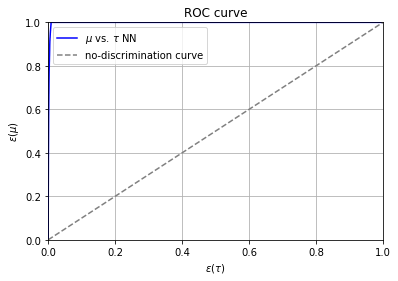

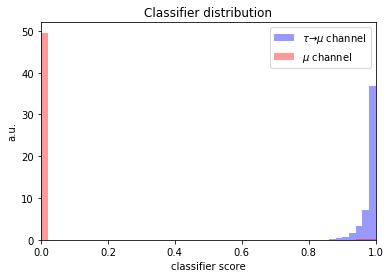

<Figure size 432x288 with 0 Axes>

In [10]:
##########################
### ROC & SCORE CURVES ###
##########################


# plot
plt.plot(fpr, tpr, label=r'$\mu$ vs. $\tau$ NN', color='b')
# plot also the diagonal, that corresponds to random picks, no discrimination power
xy = [i*j for i,j in product([10.**i for i in range(-8, 0)], [1,2,4,8])]+[1]
plt.plot(xy, xy, color='grey', linestyle='--', label='no-discrimination curve')
# cosmetics
plt.title('ROC curve')
plt.xlabel(r'$\epsilon(\tau)$')
plt.ylabel(r'$\epsilon(\mu)$')
# axis range
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
# grid
plt.grid(True)
# legend
plt.legend(loc='best')
# save figure and then clean it
plt.savefig('graphs/kinLHCb_roc.pdf')
plt.show()
#plt.clf()

# plot the discriminator shape for the muon and tau channel
test_tau = test[test.tau_pt>=0]
test_mu  = test[test.tau_pt <0]
sb.distplot(test_tau['nn_score'], kde=False, norm_hist=True, label=r'$\tau\to\mu$ channel', color='b')
sb.distplot(test_mu ['nn_score'], kde=False, norm_hist=True, label=r'$\mu$ channel' , color='r')
plt.title('Classifier distribution')
plt.xlabel('classifier score')
plt.ylabel('a.u.')
plt.xlim([0.0, 1.0])
plt.legend(loc='upper right')
plt.savefig('graphs/kinLHCb_score.pdf')
plt.show()
plt.clf()

In [11]:
# compute the auc
auroc = auc(fpr, tpr)
print "AUC =", auroc 

# compute Gini index
print "Gini index =", (auroc-0.5)*2

AUC = 0.9981623794276929
Gini index = 0.9963247588553859
